In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample

In [2]:
def generate_data(distrib,*args):
    return distrib(*args)
def mean(values, axis=None):
    """Function to use in bootstrap

    Parameters
    ----------
    values : data to average
    axis : axis or axes along which average
    Returns
    ----------
    mean : ndarray
        Average
    """
    if axis==None:
        return np.mean(values)
    else:
        return np.mean(values, axis=axis)
def resampling(values,B):
    """Creates B samples for the bootstrap (with replacements)
    
    Parameters
    ----------
    values : ndarray
        data to use 
    B : int
        number of samples needed
    Returns
    ----------
    x_resampled : ndarray
        array with dim0=B+1, contains the B samples and the original data in 
    the last position of the first axis (x_resampled[-1,:,:])
    
    """
    if B==1:
        return resample(values,replace=True)
    else:
        x_resampled = values
        x_resampled = np.expand_dims(x_resampled,axis=0)
        for i in range(B):
            x_resampled = np.insert(x_resampled,-1,resample(values,replace=True),axis=0)
        return x_resampled

### Normal distribution : Efficiency of the bootstrap method

In [4]:
n =1000
B = 1000
data = generate_data(np.random.normal,0.,0.01,n)
x_resampled = resampling(data,B)

In [73]:
resample(data,replace=True).shape

(1000,)

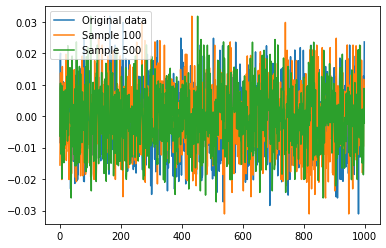

In [5]:
plt.plot(data,label='Original data')
plt.plot(x_resampled[100],label='Sample 100')
plt.plot(x_resampled[500],label='Sample 500')
plt.legend()

In [6]:
means = [mean(i) for i in x_resampled]
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = np.percentile(means, p)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(means, p)

Text(0.5, 1.0, 'Distibution mean')

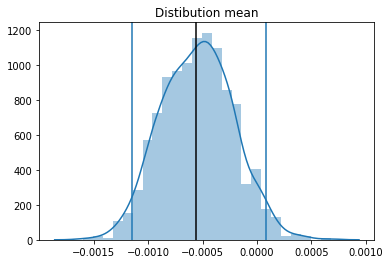

In [7]:
fig,ax = plt.subplots()
sns.distplot(means)
ax.axvline(lower)
ax.axvline(upper)
ax.axvline(means[-1],c='k')
ax.set_title('Distibution mean')

In [8]:
print('Distribution true mean : 0.')
print('Original data mean : %s'% np.around(means[-1],decimals=5))

Distribution true mean : 0.
Original data mean : -0.00056


#### Analytic confidence interval  (CI): 
$[\bar x-t_\alpha\frac{\sigma}{\sqrt n},\bar x+t_\alpha\frac{\sigma}{\sqrt n}]$ ; for a 95% CI, $t_{95}$=1.96

In [9]:
sig = np.std(data)
low = mean(data)-1.66*sig/np.sqrt(n)
upp = mean(data)+1.66*sig/np.sqrt(n)

In [10]:
print('Analytic lower bound : %s   ;   Analytic upper bound : %s'%(low,upp))
print('Bootstrap lower bound : %s   ;   Bootstrap upper bound : %s'%(lower,upper))
print('Ratio lower bound : %s   ;   Ratio upper bound : %s'%(lower/low,upper/upp))

Analytic lower bound : -0.0010962567021525435   ;   Analytic upper bound : -3.342683991683197e-05
Bootstrap lower bound : -0.0011515351723899987   ;   Bootstrap upper bound : 7.9107024571322e-05
Ratio lower bound : 1.0504247500871957   ;   Ratio upper bound : -2.3665720351712918


### 2D data:
We want now to test bootstrap method on a case closer to our case "real" (computing of MKE(y)):

#### 1) generation of a 2D data
#### 2) Estimation of the confidence interval for the average along one axis
#### A function (bootstrap) is defined to compute confidence interval using the bootstrap method for original 2D data

In [59]:
data = np.random.exponential(1.,(10,100))
data10 = data[:,::10]

In [60]:
B = 3
res = resampling(data,B)
n = mean(res[0,:,:],axis=0).size
true_mean = mean(res[-1,:,:],axis=(0))

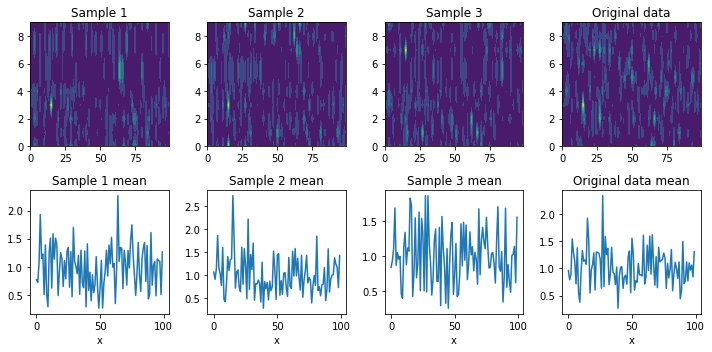

In [61]:
fig = plt.figure(figsize=(10,5))

for j in range(0,res.shape[0]-1):
    xmean = mean(res[j],axis=0)
    ax = fig.add_subplot(2,res.shape[0],j+1)
    ax.contourf(res[j])
    ax.set_title('Sample %s'%(j+1))
    ax = fig.add_subplot(2,res.shape[0],j+res.shape[0]+1)
    ax.plot(xmean)
    ax.set_title('Sample %s mean'%(j+1))
    ax.set_xlabel('x')
ax = fig.add_subplot(2,res.shape[0],4)
ax.contourf(res[-1])
ax.set_title('Original data')
ax = fig.add_subplot(2,res.shape[0],2*res.shape[0])
ax.plot(mean(data,axis=0))
ax.set_title('Original data mean')
ax.set_xlabel('x')
plt.tight_layout()

In [62]:
def bootstrap(values,distrib,B,stats,axis,t,*args_distrib):
    """Boostrap method
    
    Parameters
    ----------
    values : ndarray
        data or None if random generation of data following a specific distribution wanted
    idstri
    args_distrib : 
        args for chosen distribution
    B : int
        number of resampling
    stats : func 
        estimator (function to define)
    axis : int
        axis along which the stat function will be applied
    t : float
        parameter defining the confidence interval
    Returns
    ----------
    x_samples : ndarray
        array containing all the resampled data and the original data
    var : list
        variance computed using bootstrap method
    low : list
        lower bound of the confidence interval
    high : list
        upper bound of the confidence interval
    """
    if values is None:
        values = generate_data(distrib,*args_distrib)
    x_samples = resampling(values,B)
    n = stats(x_samples[-1,:,:],axis=axis).size
    means = mean(x_samples,axis+1)
    low = []
    high = []
    val = []
    p = ((1-t)/2) * 100
    p_ = ((1+t)/2) * 100
    for j in range(x_samples.shape[1]):
        _m = means[:,j]
        low.append(np.percentile(_m, p))
        high.append(np.percentile(_m, p_))
        val.append(_m[-1])
    return x_samples,val,low,high #x_samples, 1/B*var, 1/B*tst#1/B*tst
def plot_CI(low,upp,val):
    plt.plot(val,label='Averaged original data')
    plt.plot(low,label='Lower bound of the CI')
    plt.plot(upp,label='Upper bound of the CI')

In [43]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
#d100 = generate_data(np.random.normal,0,1,(10,100))
#d10 = d100[:,::10]#generate_data(np.random.normal,0,1,(10,10))
b = np.arange(10,1000,100)
#x10 = np.arange(0,d10.shape[1])
#x100 = np.arange(0,d100.shape[1])
Nc = len(b)
x10 = np.arange(0,data.shape[0])
cmap = 'seismic'
scalarMap = cmx.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=Nc),
                               cmap=cmap)
clrs = [scalarMap.to_rgba(i) for i in range(Nc)]

### Impact of the number of samples and the number of on the yaxis : 
#### Left column is different number of samples for a dataset with 100 points on the yaxis
#### Right column is the same but for 10 points on the yaxis

#### Last line corresponds to the averaged original data (black line) and the confidence interval (dashed lines) for different number of samples

In [46]:
d100 = generate_data(np.random.normal,0,1,(10,100))
d10 = d100[:,::10]#generate_data(np.random.normal,0,1,(10,10))
b = np.arange(10,1000,100)
#x10 = np.arange(0,d10.shape[1])
#x100 = np.arange(0,d100.shape[1])
Nc = len(b)

/opt/anaconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/opt/anaconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


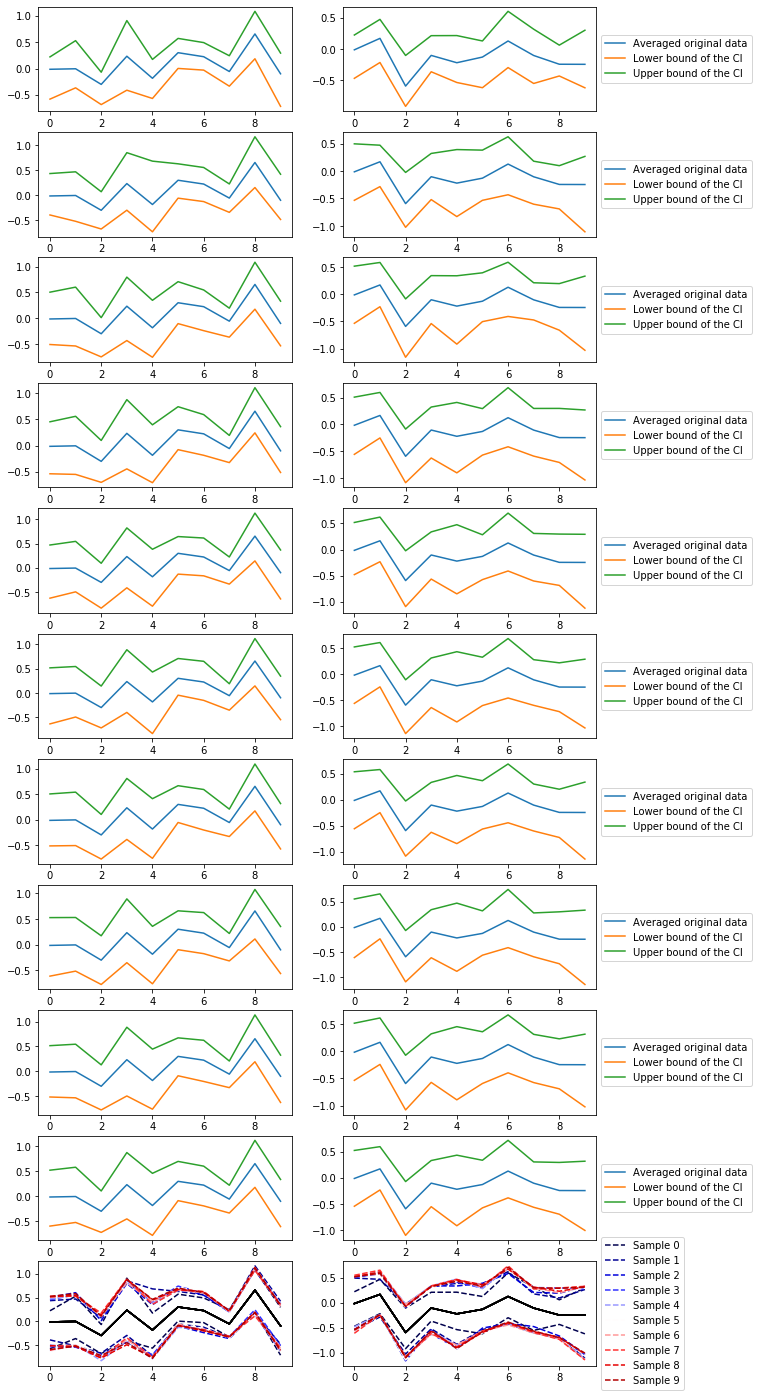

In [47]:
cmap = 'seismic'
scalarMap = cmx.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=Nc),
                               cmap=cmap)
clrs = [scalarMap.to_rgba(i) for i in range(Nc)]

plt.figure(figsize=(10,25))
grid = plt.GridSpec(len(b)+1, 2)#, wspace=0.4, hspace=0.3)
for i,j in enumerate(b):
    x_samp,val,low,upp = bootstrap(d10,[],j,mean,0,0.95)
    plt.subplot(grid[i,0])
    plot_CI(low,upp,val)
    #plt.legend()
    plt.subplot(grid[-1,0])
    plt.plot(x10,low,'--',color=clrs[i])
    plt.plot(x10,val,'k')
    plt.plot(x10,upp,'--',color=clrs[i])
    
    x_samp,val,low,upp = bootstrap(d100,[],j,mean,0,0.95)
    plt.subplot(grid[i,1])
    plot_CI(low,upp,val)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.subplot(grid[-1,1])
    plt.plot(x10,low,'--',color=clrs[i],label='Sample %s'%i)
    plt.plot(x10,val,'k')
    plt.plot(x10,upp,'--',color=clrs[i])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))